In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds
#%config InlineBackend.figure_format = 'retina'

# Função objetivo da otimização. Objetivo: minimizar desvio_padrao_queda / rendimento_medio_diario
# def funcao_objetivo(pesos):
#     pesos_carteiras.append(pesos)
#     calculo = pd.DataFrame()
#     calculo['variacao_dia'] = (precos.pct_change() * pesos).sum(axis=1) # variação diária do valor da carteira
#     calculo = calculo[1:] # descarta a primeira linha
#     variacao_diaria_media = calculo['variacao_dia'].mean() # variação diária média do valor carteira
#     retornos.append(variacao_diaria_media)
#     #desvio_padrao = calculo[calculo.variacao_dia < 0]['variacao_dia'].std() # desvio padrão dos dias de queda
#     desvio_padrao = calculo['variacao_dia'].std()
#     volatilidades.append(desvio_padrao)
#     sharpe_ratio.append(variacao_diaria_media / desvio_padrao)
    
#     return desvio_padrao / variacao_diaria_media

def calcular_rendimento_acumumulado():
    return ((precos.pct_change() + 1).cumprod() - 1) * 100

def formatar_resultado(result, simbolos):
    resultado = []
    pesos = result.x / sum(result.x) * 100
    for i in range(len(simbolos)):
        resultado.append( simbolos[i] + ": " + "%.4f" % pesos[i])

    return resultado

def constraint_f(x):
    return np.array(sum(x))

def desempenho_carteira(pesos, variacao_diaria_media, cov_matrix, qtd_dias):
    retorno = np.sum(variacao_diaria_media * pesos ) * qtd_dias
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(qtd_dias)
    return std, returns

<AxesSubplot:title={'center':'Rendimento dos ativos no período'}>

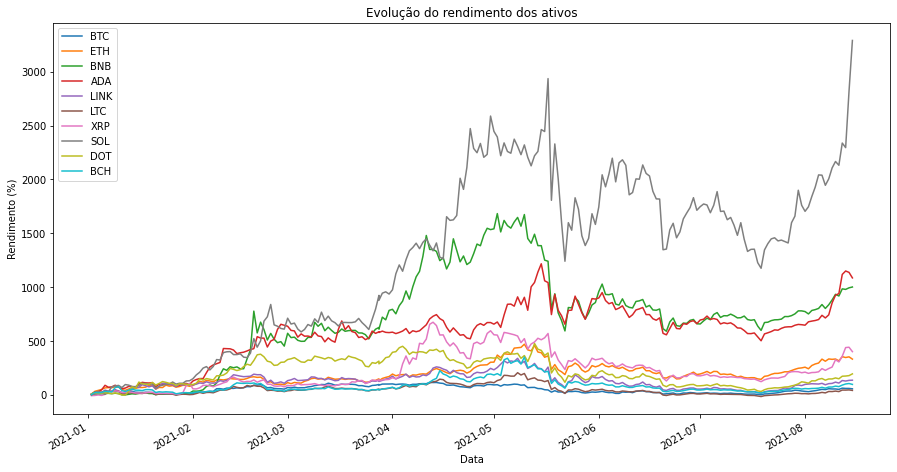

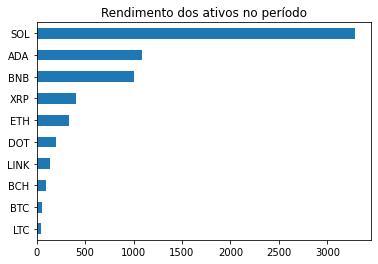

In [3]:
precos = pd.read_csv("../dados/cotacoes.csv", index_col=0, parse_dates=True)

# evolução do rendimento
rendimento_acumulado = calcular_rendimento_acumumulado()
rendimento_acumulado = rendimento_acumulado[1:]
rendimento_acumulado.plot(title='Evolução do rendimento dos ativos', xlabel='Data', ylabel='Rendimento (%)', figsize=(15,8))
# rendimento no final do período
rendimento_final = rendimento_acumulado[-1:].T
rendimento_final = rendimento_final.sort_values(by=rendimento_final.columns.tolist()[0])
rendimento_final.plot(kind='barh', title='Rendimento dos ativos no período', legend=False)

In [4]:
rendimento_acumulado

,BTC,ETH,BNB,ADA,LINK,LTC,XRP,SOL,DOT,BCH
Date,,,,,,,,,,
2021-01-02,9.372578,6.047287,0.887962,1.182210,2.927608,8.488085,-6.649569,-2.323944,10.858761,3.688543
2021-01-03,11.601598,33.563941,8.558154,16.906194,14.972493,26.903385,-4.883675,17.353602,20.783699,23.335540
2021-01-04,8.843699,42.425964,7.970828,28.179070,14.306173,22.638756,-0.323020,34.906816,13.998044,19.284804
2021-01-05,15.722249,50.609936,10.103123,47.313385,22.466214,25.639180,-4.503798,17.107416,16.791474,22.744366
2021-01-06,25.363152,65.274618,11.241111,89.277452,44.495069,33.895633,5.664913,4.730128,21.539526,32.895670
...,...,...,...,...,...,...,...,...,...,...
2021-08-11,51.249604,316.696264,917.857448,940.135784,109.872558,30.817218,306.221682,2131.133884,149.852641,76.910199
2021-08-12,62.705360,354.868464,984.143977,1118.180284,133.590307,45.199702,359.038757,2337.158105,173.439804,91.223954
2021-08-13,60.334653,347.095896,979.104009,1149.892879,128.724337,44.744333,439.247977,2294.725158,175.207957,101.504026


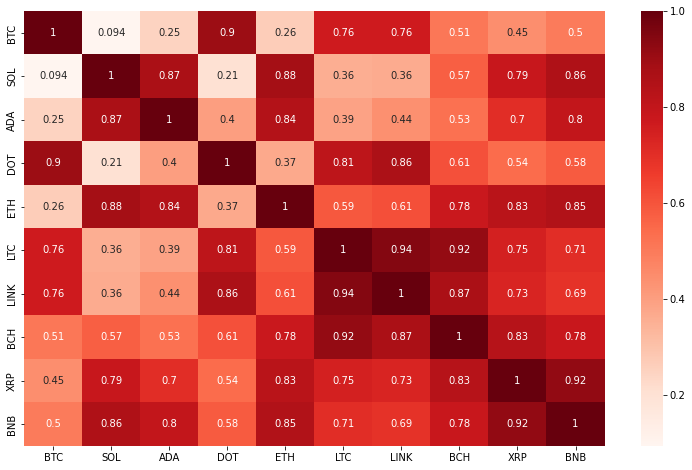

In [5]:
# Get correlation and sort by sum
sum_corr = precos.corr().sum().sort_values(ascending=True).index.values
correlacoes = precos[sum_corr].corr()

plt.figure(figsize=(13, 8))
sns.heatmap(correlacoes, annot=True, cmap='Reds');

In [17]:
variacao_diaria = precos.pct_change()
variacao_diaria = variacao_diaria[1:]
variacao_diaria_media = variacao_diaria.mean()
cov_matrix = variacao_diaria.cov()
qtd_carteiras = 1000

In [20]:
variacao_diaria_media * [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

BTC     0.001522
ETH     0.004245
BNB     0.007243
ADA     0.006904
LINK    0.003554
LTC     0.001921
XRP     0.005660
SOL     0.010070
DOT     0.004135
BCH     0.003120
dtype: float64

In [9]:
# dados das carteiras geradas na simulação
pesos_carteiras = []
retornos = []
volatilidades = []
sharpe_ratio = []

simbolos = precos.columns.tolist()
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos)
constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # restrição para soma dos pesos ser igual a 1
result = optimize.minimize(funcao_objetivo, initial_guess, method='SLSQP', bounds=bounds, constraints=constraint, options={'maxiter':1000, "disp":True})
# 4.1552550027116375
# formatar_resultado(result, simbolos)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.1552550027116375
            Iterations: 9
            Function evaluations: 101
            Gradient evaluations: 9


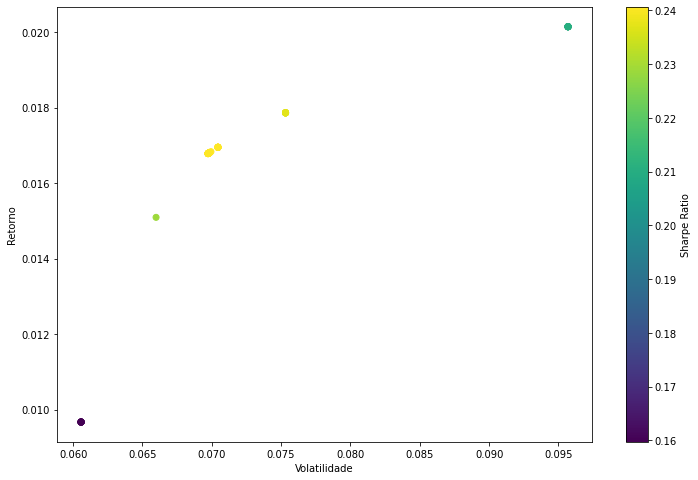

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(volatilidades, retornos, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
# plt.scatter(max_vol, max_ret,c='red', s=50) # red dot
plt.show()

In [11]:
# dados das carteiras geradas na simulação
# pesos_carteiras = []
# retornos = []
# volatilidades = []
# sharpe_ratio = []

# nlc = NonlinearConstraint(constraint_f, np.NINF, 1)
# result = optimize.differential_evolution(funcao_objetivo, bounds=bounds, constraints=nlc, strategy='best2exp')

In [ ]:
# print(result.fun)
# print(len(retornos))
# 4.1552550027116375
# 4.155255274629884

In [ ]:
# plt.figure(figsize=(12,8))
# plt.scatter(volatilidades, retornos, c=sharpe_ratio, cmap='viridis')
# plt.colorbar(label='Sharpe Ratio')
# plt.xlabel('Volatilidade')
# plt.ylabel('Retorno')
# # plt.scatter(max_vol, max_ret,c='red', s=50) # red dot
# plt.show()

In [ ]:
# fig1, ax1 = plt.subplots()
# ax1.pie(pesos, labels=simbolos, autopct='%1.1f%%', shadow=True, startangle=90, normalize=True)
# ax1.axis('equal')
# plt.title("Carteira")